In [1]:
import import_ipynb
from Functions import *

importing Jupyter notebook from Functions.ipynb


# Feature Extraction

In [2]:
def extract_features(Frames):
    # Pixel Differences 
    diff_pix = [Frames[i]-Frames[i+1] for i in range(len(Frames)-1)]
    diff_pix = torch.vstack(diff_pix)
    #diff_pix = diff_pix/diff_pix.max() if diff_pix.max()!=0 else diff_pix/(diff_pix.max()+1e-10)
    #print("dif: ",diff_pix.shape)
    
    # Edges Frames
    edge_frames = [Edges_tensor(Frames[i]) for i in range(len(Frames))]
    edge_frames = torch.vstack(edge_frames)
    #edge_frames = edge_frames/edge_frames.max() if edge_frames.max()!=0 else edge_frames/(edge_frames.max()+1e-10)
    #print("edges: ",edge_frames.shape)
        
    #SSIM    
    Scores = [TSSIM(Frames[i].unsqueeze(0),Frames[i+1].unsqueeze(0)) for i in range(len(Frames)-1)]
    Score = [t[0].item() for t in Scores]
    SimScores = torch.cat([t[1].squeeze(0) for t in Scores])
    #SimScores = SimScores/SimScores.max() if SimScores.max()!=0 else SimScores/(SimScores.max()+1e-10)
    #print("SSIM: ",SimScores.shape)
        
    #Optical Flow    
    OpFlow = torch.vstack([for i in range(len(Frames)-1)])
    #OpFlow = OpFlow/OpFlow.max() if OpFlow.max()!=0 else OpFlow/(OpFlow.max()+1e-10)
    #print("OF: ",OpFlow.shape)
    
    Frames = torch.cat(Frames)
    #print(Frames.shape)

    #Concatenate all features
    features = torch.cat([Frames,diff_pix, edge_frames, SimScores, ])#, OpFlow])
    #print("Features: ",features.shape)
    return features

# Main Model

In [3]:
class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()

        # First convolutional block
        self.conv1 = nn.Conv2d(30, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.fpool1 = nn.FractionalMaxPool2d(kernel_size=2, output_ratio=(0.9, 0.9))

        # Second convolutional block
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.fpool2 = nn.FractionalMaxPool2d(kernel_size=2, output_ratio=(0.8, 0.8))

        # Third convolutional block
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.fpool3 = nn.FractionalMaxPool2d(kernel_size=2, output_ratio=(0.75, 0.75))

        # Feature refinement
        self.conv4 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.conv5 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(64)

        # Final layer for output
        self.conv_out = nn.Conv2d(64, 1, kernel_size=1)
        self.upsample = nn.Upsample(size=(50, 50), mode='bilinear', align_corners=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = Fun.relu(self.bn1(self.conv1(x)))
        x = self.fpool1(x)  

        x = Fun.relu(self.bn2(self.conv2(x)))
        x = self.fpool2(x)

        x = Fun.relu(self.bn3(self.conv3(x)))
        x = self.fpool3(x)

        x = Fun.relu(self.bn4(self.conv4(x)))
        x = Fun.relu(self.bn5(self.conv5(x)))

        x = self.conv_out(x)  
        x = self.upsample(x)  # Restore 50x50
        x = self.sigmoid(x)   # Normalize to [0,1]

        return x

# Training Function

In [4]:
def train(Path, state=None, N=3, Batch=10, Epochs=10, Steps=5, LR=1e-3,Stride=10):
    Size = (300, 300)  # Size of Frames
    
    # Initialize Model Shapes
    model = DNNModel()
    if state is not None:
        model.load_state_dict(state)
    model.train()
    
    # Initialize Optimizer
    optimizer = optim.Adam(model.parameters(), lr=LR)
    
    # Loss function
    criterion = nn.MSELoss()
    criterion1 = nn.BCELoss()
    
    Loss = []
    start_time = time.time()  # Track the start time of training
    
    total_batches = Epochs * Batch
    
    for epoch in range(Epochs):
        total_loss = 0.0
        epoch_start_time = time.time()
        
        for batch in range(Batch):
            batch_start_time = time.time()
            
            # Get Frames
            Frames = get_video_frames(Path, N, Size)
            IncFrames = Frames.copy()
            
            IncGrid = torch.zeros(Size[0]//25, Size[1]//25)
            BinImg = np.zeros(Size)
            Bin = torch.tensor(np.zeros(Frames[0].shape[1:]).astype(np.float32))
            
            steps = random.randint(1, Steps)
            for s in range(steps):
                x = random.randint(0, 5 * Size[0] // 6)
                y = random.randint(0, 5 * Size[1] // 6)
                xl = random.randint(10, Size[0] // 10)
                yl = random.randint(10, Size[1] // 10)
                
                for p in range(N):
                    if random.random() >= 0.5 and p != N // 2:
                        IncFrames[p], _ = AddOneInc2(torch.tensor(np.zeros(Frames[0].shape[:2]).astype(np.float32)), IncFrames[p], x=x, y=y, xl=xl, yl=yl)
                IncFrames[N // 2], Bin = AddOneInc2(Bin, IncFrames[N // 2], x=x, y=y, xl=xl, yl=yl)
                
            
            features = extract_features(IncFrames).unsqueeze(0)
            PredGrid = torch.zeros(1, 1, Size[0], Size[1])
            Bin = Bin.unsqueeze(0).unsqueeze(0)
            
            for v in range(Size[0]//Stride):
                for h in range(Size[1]//Stride):
                    if Stride*v+50<=300 and Stride*h+50<=300:
                        feat = features[:, :, v * Stride:v * Stride + 50, h * Stride:h * Stride + 50].clone().detach()
                        optimizer.zero_grad()
                        Pred = model(feat)
                        PredGrid[:, :, v * Stride:v * Stride + 50, h * Stride:h * Stride + 50] = Pred
                        b = Bin[:, :, v * Stride:v * Stride + 50, h * Stride:h * Stride + 50].clone().detach()
                        if Bin.max()>1:
                            print(Bin.max(),v,h)
                            
                        loss = criterion(Pred, b)+ \
                               criterion(Bin,torch.tensor(BinImg,dtype=torch.float32).unsqueeze(0).unsqueeze(0))+ \
                               criterion1(Pred,b)+ \
                               criterion1(Bin,torch.tensor(BinImg,dtype=torch.float32).unsqueeze(0).unsqueeze(0))
                        loss.backward()
                        optimizer.step()

                        bi = Frame2Numpy(Pred.squeeze(0).squeeze(0))
                        BinImg[v * Stride:v * Stride + 50, h * Stride:h * Stride + 50] = bi

                        elapsed_time = time.time() - start_time
                        processed_batches = epoch * Batch + batch + 1
                        remaining_batches = total_batches - processed_batches

                        if processed_batches > 0:
                            avg_time_per_batch = elapsed_time / processed_batches
                            estimated_remaining_time = avg_time_per_batch * remaining_batches
                        else:
                            estimated_remaining_time = 0

                        est_hours = int(estimated_remaining_time // 3600)
                        est_mins = int((estimated_remaining_time % 3600) // 60)
                        est_secs = int(estimated_remaining_time % 60)

                        print(f'Batch [{batch+1}/{Batch}], Loss: {loss.item():.4f}, '
                              f'ETA: {est_hours:02d}:{est_mins:02d}:{est_secs:02d}', end='\r')

                        f = Frame2Numpy(features[0, N * 3 // 2:N * 3 // 2 + 3])
                        cv2.imshow("Predicted Inconsistencies", BinImg)
                        cv2.imshow("Thresholded Prediction",(BinImg>0.5).astype(np.float32))
                        cv2.imshow("Ground Truth", Frame2Numpy(Bin.squeeze(0).squeeze(0)))
                        cv2.imshow("Inconsistencies Frame", f)
                        cv2.waitKey(10)  # Check for key press every frame

                        key = cv2.waitKey(1) & 0xFF
                        if key == 27:
                            print("Training stopped by user.")
                            cv2.destroyAllWindows()
                            return Loss, model.state_dict()

                        total_loss += loss.item()
                    
        epoch_time = time.time() - epoch_start_time
        print(f'\nEpoch [{epoch + 1}/{Epochs}], Loss: {total_loss / (Batch * 11 * 11):.6f}')
        
        LR *= 0.9
        Loss.append(total_loss)
    
    states = model.state_dict()
    cv2.destroyAllWindows()
    return Loss, states


# Training

In [123]:
cv2.destroyAllWindows()

In [124]:
State = None#torch.load("StatesBID3N300x300V10.pth")

In [125]:
L,State = train('VDB/Toons',Batch=50,state=State,N=3,Epochs=20,Steps=25,LR=1e-4,Stride=50)

Batch [50/50], Loss: 7.7516, ETA: 01:42:076
Epoch [1/20], Loss: 3.117377
Batch [50/50], Loss: 3.5773, ETA: 01:36:301
Epoch [2/20], Loss: 1.478269
Batch [50/50], Loss: 5.0317, ETA: 01:31:045
Epoch [3/20], Loss: 1.564615
Batch [50/50], Loss: 3.1076, ETA: 01:25:37
Epoch [4/20], Loss: 1.223787
Batch [50/50], Loss: 1.8926, ETA: 01:21:014
Epoch [5/20], Loss: 1.338302
Batch [50/50], Loss: 2.1346, ETA: 01:15:278
Epoch [6/20], Loss: 1.210068
Batch [50/50], Loss: 4.6285, ETA: 01:10:000
Epoch [7/20], Loss: 1.298418
Batch [50/50], Loss: 4.0921, ETA: 01:04:32
Epoch [8/20], Loss: 1.252693
Batch [50/50], Loss: 4.1321, ETA: 00:59:07
Epoch [9/20], Loss: 1.210036
Batch [50/50], Loss: 3.7822, ETA: 00:53:484
Epoch [10/20], Loss: 1.393379
Batch [50/50], Loss: 1.7665, ETA: 00:48:23
Epoch [11/20], Loss: 1.192489
Batch [50/50], Loss: 5.7141, ETA: 00:43:019
Epoch [12/20], Loss: 1.271040
Batch [50/50], Loss: 4.4479, ETA: 00:37:402
Epoch [13/20], Loss: 1.365043
Batch [50/50], Loss: 1.8994, ETA: 00:32:17
Epoch [1

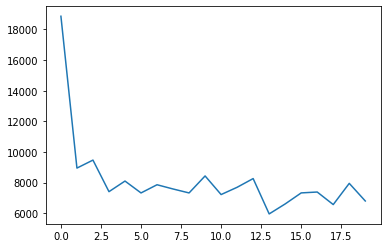

In [126]:
plt.plot(L) ##Cambios de Escenas

In [5]:
torch.save(State,"StatesBID3N300x300V10.pth")

NameError: name 'State' is not defined

# Load and Predict

In [6]:
States = torch.load("StatesBID3N300x300V10.pth")

In [7]:
Size = (300,300)
Model = DNNModel()
Model.load_state_dict(States)
Model.eval();

In [8]:
Frames = get_video_frames("AI Gen",3,Size)
Frames_Np = [cv2.cvtColor(Frames[n].permute(1, 2, 0).numpy(), cv2.COLOR_BGR2RGB) for n in range(len(Frames))]

In [9]:
ThroughFrames(Frames_Np)

In [11]:
features = extract_features(Frames).unsqueeze(0)

TypeError: not enough arguments: expected 3, got 2

In [139]:
PredImg = np.zeros((300,300))
for v in range(0, 6):
    for h in range(0, 6):
        feat = features[:, :, v * 50:(v + 1) * 50, h * 50:(h + 1) * 50].clone().detach()
        Pred = Model(feat)
        PredImg[v * 50:(v + 1) * 50, h * 50:(h + 1) * 50] = Frame2Numpy(Pred.squeeze(0).squeeze(0))

In [140]:
TPred = (PredImg>0.5).astype(np.float32)
NF = [cv2.cvtColor(Frame2Numpy(f),cv2.COLOR_BGR2RGB) for f in Frames]
IFrame = NF[1].copy()
IFrame[TPred == 1] = np.array([0, 255, 0], dtype=np.uint8)

In [141]:
display_images([PredImg,TPred]+NF+[IFrame])

In [ ]:
### Add OF and more frames
### 

In [15]:
def calculate_optical_flow(Frame1, Frame2):
    """
    Compute dense optical flow between two RGB frames using all three channels.
    """
    Frame1_gray = cv2.cvtColor(Frame1, cv2.COLOR_BGR2GRAY)
    Frame2_gray = cv2.cvtColor(Frame2, cv2.COLOR_BGR2GRAY)
    
    # Calculate dense optical flow using Farneback method
    flow = cv2.calcOpticalFlowFarneback(Frame1_gray, Frame2_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    return flow

def warp_image(Frame1, flow):
    """
    Warp an image using the optical flow field.
    """
    h, w = flow.shape[:2]
    
    # Create a grid of pixel coordinates (x, y)
    x, y = np.meshgrid(np.arange(w), np.arange(h))
    
    # Compute new pixel locations by adding flow vectors
    remap_x = (x + flow[..., 0]).astype(np.float32)
    remap_y = (y + flow[..., 1]).astype(np.float32)
    
    # Remap using the computed optical flow
    warped = cv2.remap(Frame1, remap_x, remap_y, cv2.INTER_LINEAR)
    
    return warped

In [35]:
Frames = get_video_frames("VDB/Toons",2,(300,300))
Frame1 = cv2.cvtColor(Frame2Numpy(Frames[0]),cv2.COLOR_RGB2BGR)
Frame2 = cv2.cvtColor(Frame2Numpy(Frames[1]),cv2.COLOR_RGB2BGR)
ThroughFrames([Frame1,Frame2])

In [42]:
flow = calculate_optical_flow(Frame1, Frame2)
warped_Frame1 = warp_image(Frame1, flow*1e7)
display_images([Frame1,Frame2,warped_Frame1,abs(Frame2-warped_Frame1)])

In [23]:
def warp_image(image: torch.Tensor, flow: torch.Tensor) -> torch.Tensor:
    """
    Warp an image given an optical flow tensor.

    Args:
        image (torch.Tensor): The input RGB image tensor of shape (B, C, H, W).
        flow (torch.Tensor): The optical flow tensor of shape (B, 2, H, W).

    Returns:
        torch.Tensor: The warped image tensor of shape (B, C, H, W).
    """
    import torch.nn.functional as Fun  # Import functional module
    
    B, C, H, W = image.shape

    # Generate a mesh grid of coordinates (height, width)
    grid_y, grid_x = torch.meshgrid(torch.arange(H, device=image.device), 
                                    torch.arange(W, device=image.device), indexing='ij')
    grid = torch.stack((grid_x, grid_y), dim=-1).float()  # shape: (H, W, 2)

    # Normalize the grid to the range [-1, 1]
    grid = 2.0 * grid / torch.tensor([W - 1, H - 1], device=image.device) - 1.0  # scale to [-1, 1]
    grid = grid.view(1, H, W, 2).repeat(B, 1, 1, 1)  # Use `.repeat()` instead of `.expand()`

    # Add the optical flow to the grid
    flow = flow.permute(0, 2, 3, 1)  # (B, 2, H, W) -> (B, H, W, 2)

    # Normalize the flow by the image dimensions (width and height) to match the grid's [-1, 1] range
    flow = flow / torch.tensor([W, H], device=image.device)

    # Clone grid before modifying it
    grid = grid.clone() + flow  

    # Sample the image using the new grid
    warped_image = Fun.grid_sample(image, grid, mode='bilinear', padding_mode='zeros', align_corners=True)

    return warped_image


In [28]:
Frames = get_video_frames("VDB",2,(300,300))
frames = [cv2.cvtColor(Frame2Numpy(f),cv2.COLOR_RGB2BGR) for f in Frames]

In [29]:
ThroughFrames(frames)

In [30]:
Flow = torch.ones(1,2,300,300)*10

In [31]:
WFrame = warp_image(Frames[0].unsqueeze(0),Flow)
display_frame(cv2.cvtColor(Frame2Numpy(WFrame.squeeze(0)),cv2.COLOR_BGR2RGB))

In [34]:
(Frames[1]-WFrame).backward()

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [22]:
B, C, H, W = 2, 3, 128, 128  # Batch size, channels, height, width
image = torch.randn(B, C, H, W, requires_grad=True)  # Input image
flow = torch.randn(B, 2, H, W, requires_grad=True)  # Optical flow

# Target image (for loss calculation)
target_image = torch.randn(B, C, H, W)  

# Compute the warped image
warped_image = warp_image(image, flow)

# Define a loss function (e.g., MSE loss with the target image)
loss = Fun.mse_loss(warped_image, target_image)

# Backpropagate
loss.backward()

In [33]:
Imgs = get_video_frames("VDB/Toons",2,(400,400))

In [34]:
ThroughFrames([Frame2Numpy(f) for f in Imgs])

In [35]:
img0 = Frame2Numpy(Imgs[0])
img1 = Frame2Numpy(Imgs[1])
Imgs[0].requires_grad_()
Imgs[1].requires_grad_()
flow = pyramid_optical_flow(Imgs[0],Imgs[1],1)
flow1 = pyramid_optical_flow(Imgs[0],Imgs[1],2)
flow2 = pyramid_optical_flow(Imgs[0],Imgs[1],3)
flow3 = pyramid_optical_flow(Imgs[0],Imgs[1],4)
Wimg = warp_image_tensor(Imgs[0].unsqueeze(0),flow.unsqueeze(0))
wimg1 = Frame2Numpy(Wimg.squeeze(0))
Wimg1 = warp_image_tensor(Imgs[0].unsqueeze(0),flow1.unsqueeze(0))
wimg2 = Frame2Numpy(Wimg1.squeeze(0))
Wimg2 = warp_image_tensor(Imgs[0].unsqueeze(0),flow2.unsqueeze(0))
wimg3 = Frame2Numpy(Wimg2.squeeze(0))
Wimg3 = warp_image_tensor(Imgs[0].unsqueeze(0),flow3.unsqueeze(0))
wimg4 = Frame2Numpy(Wimg3.squeeze(0))
criterion = nn.MSELoss()
loss = criterion(Wimg,Wimg1)
loss.backward()

In [36]:
ThroughFrames([img0,wimg1,wimg2,wimg3,wimg4])
((img1-wimg1)**2).sum(),((img1-wimg2)**2).sum(),((img1-wimg3)**2).sum(),((img1-wimg4)**2).sum()

(1802.6007, 1010.8973, 1686.9662, 3639.0742)

In [24]:
# Example usage:
image_tensor = get_video_frames("VDB\Toons",1,(300,300))[0].requires_grad_()  # Example RGB image
segmented_image = differentiable_segmentation(image_tensor, num_clusters=5,sigma=0.1)

# Display using OpenCV
display_images([Frame2Numpy(image_tensor),Frame2Numpy(segmented_image)])

crit = nn.MSELoss()
loss = crit(image_tensor,segmented_image)
loss.backward()

In [41]:
# Example usage:
image_tensor = get_video_frames("VDB\Toons",1,(300,300))[0].requires_grad_()

# Apply differentiable segmentation
num_clusters = 2  # Change the number of clusters as needed
segmented_rgb = differentiable_segmentationRGB(image_tensor, num_clusters)

display_images([Frame2Numpy(image_tensor),Frame2Numpy(segmented_rgb),Frame2Numpy(image_tensor)-Frame2Numpy(segmented_rgb),Frame2Numpy(segmented_rgb)-Frame2Numpy(image_tensor)])
crit = nn.MSELoss()
loss = crit(image_tensor,segmented_rgb)
loss.backward()

In [39]:
# Example usage:
image_tensor = get_video_frames("VDB\Toons",2,(300,300))
img1 = image_tensor[0].requires_grad_()
img2 = image_tensor[1]
# Apply differentiable segmentation
num_clusters = 2  # Change the number of clusters as needed
segmented_rgb1 = differentiable_segmentationRGB(img1, num_clusters)
segmented_rgb2 = differentiable_segmentationRGB(img2, num_clusters)

flow = pyramid_optical_flow(segmented_rgb1,segmented_rgb2,alpha=5.0)
flow1 = pyramid_optical_flow(segmented_rgb1,segmented_rgb2,alpha=10.0)
wimg = warp_image_tensor(segmented_rgb1.unsqueeze(0),flow.unsqueeze(0)).squeeze(0)
wimg1 = warp_image_tensor(segmented_rgb1.unsqueeze(0),flow1.unsqueeze(0)).squeeze(0)
ThroughFrames([Frame2Numpy(segmented_rgb1),Frame2Numpy(segmented_rgb2),Frame2Numpy(segmented_rgb1),Frame2Numpy(wimg),Frame2Numpy(wimg1)])
display_images([Frame2Numpy(segmented_rgb1),Frame2Numpy(segmented_rgb2),Frame2Numpy(wimg),Frame2Numpy(wimg1),Frame2Numpy(segmented_rgb2)-Frame2Numpy(wimg),Frame2Numpy(segmented_rgb2)-Frame2Numpy(wimg1)])
crit = nn.MSELoss()
loss = crit(segmented_rgb2,wimg)
loss.backward()
((Frame2Numpy(segmented_rgb2)-Frame2Numpy(wimg))**2).sum(),((Frame2Numpy(segmented_rgb2)-Frame2Numpy(wimg1))**2).sum()

(16855.816, 17534.89)